# Installing Requirments

In [ ]:
# Install required packages
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

# Imports and Device Setup

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# Set plot style
plt.style.use('seaborn-v0_8-ticks')

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cuda


# Load IMDb Dataset

In [ ]:
data = load_dataset("imdb")
df_train = pd.DataFrame(data['train'])
df_test = pd.DataFrame(data['test'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Shuffle and stratified split

In [ ]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_train, df_test = train_test_split(
    df_all,
    test_size=1000,
    train_size=6000,
    stratify=df_all["label"],
    random_state=42
)

print(df_train["label"].value_counts())
print(df_test["label"].value_counts())

label
0    3000
1    3000
Name: count, dtype: int64
label
1    500
0    500
Name: count, dtype: int64


# Label Distribution and Review Length

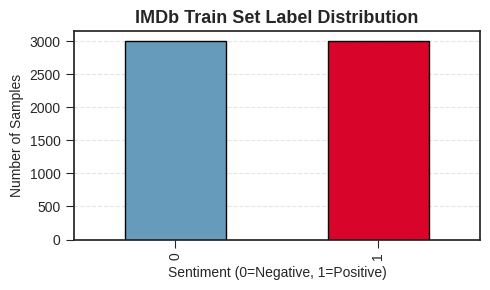

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
colors = ['#669bbc', '#d90429']
df_train['label'].value_counts().plot(kind='bar', color=colors, ax=ax, edgecolor='black')
ax.set_title('IMDb Train Set Label Distribution', fontsize=13, fontweight='bold')
ax.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax.set_ylabel('Number of Samples')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

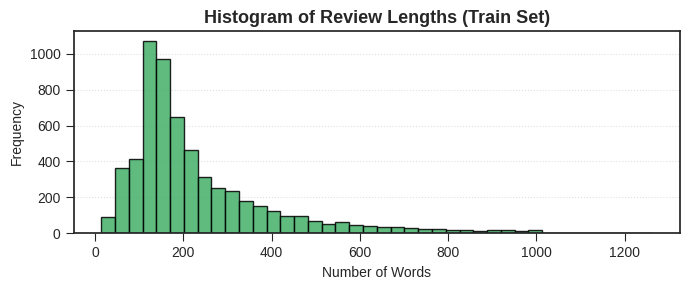

In [ ]:
plt.figure(figsize=(7,3))
df_train['review_length'] = df_train['text'].apply(lambda x: len(x.split()))
plt.hist(df_train['review_length'], bins=40, color='#44af69', edgecolor='black', alpha=0.85)
plt.title('Histogram of Review Lengths (Train Set)', fontsize=13, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Word Clouds for Positive/Negative Reviews

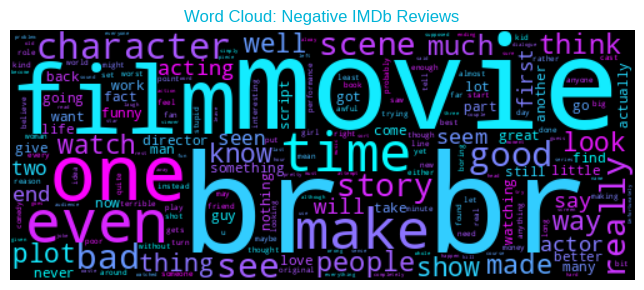

In [ ]:
neg_reviews = " ".join(df_train[df_train['label']==0]['text'])
pos_reviews = " ".join(df_train[df_train['label']==1]['text'])

wordcloud_neg = WordCloud(width=500, height=200, background_color='black', colormap='cool').generate(neg_reviews)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative IMDb Reviews', fontsize=12, color='#00b4d8')
plt.tight_layout()
plt.show()

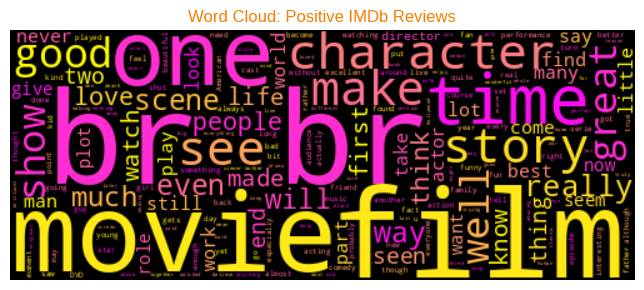

In [ ]:
wordcloud_pos = WordCloud(width=500, height=200, background_color='black', colormap='spring').generate(pos_reviews)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive IMDb Reviews', fontsize=12, color='#f77f00')
plt.tight_layout()
plt.show()

# Prepare Training and Test Lists

In [ ]:
train_texts = df_train['text'].tolist()
train_labels = df_train['label'].tolist()
test_texts = df_test['text'].tolist()
test_labels = df_test['label'].tolist()

# Define Custom Dataset Class for PyTorch

In [ ]:
class TextReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, index):
        encoded = self.tokenizer(self.reviews[index],
                                 truncation=True,
                                 padding='max_length',
                                 max_length=self.max_len,
                                 return_tensors='pt')
        data_item = {key: val.squeeze(0) for key, val in encoded.items()}
        data_item['labels'] = torch.tensor(self.targets[index], dtype=torch.long)
        return data_item

# Tokenizer & DataLoader Setup

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_length = 256

train_dataset = TextReviewDataset(train_texts, train_labels, tokenizer, max_seq_length)
test_dataset = TextReviewDataset(test_texts, test_labels, tokenizer, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Initialize BERT Model for Sequence Classification

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()

# Show Sample Comments and Labels (Before Training)

print("\nSample IMDb test reviews and labels (before training):\n")
for i in range(3):
    print(f"Review: {test_texts[i][:120]}...")
    print(f"True label: {test_labels[i]}")
    print("")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sample IMDb test reviews and labels (before training):

Review: "Film noir" is an overused expression when it comes to describing films. Every crime drama seems to be a "noir". But "Wh...
True label: 1

Review: An amazing piece of film that was well-conceived and kept me on the edge of my seat. Brilliantly orchestrated in its tim...
True label: 1

Review: The movie was very good. I'm an avid mystery fan and I usually figure out who is going to be killed and who did the kill...
True label: 1



# Training Model

In [ ]:
num_epochs = 10  # For demo purposes; increase for better accuracy!
train_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {avg_train_loss:.4f}")

Epoch 1/10 | Training Loss: 0.3327
Epoch 2/10 | Training Loss: 0.1478
Epoch 3/10 | Training Loss: 0.0646
Epoch 4/10 | Training Loss: 0.0393
Epoch 5/10 | Training Loss: 0.0350
Epoch 6/10 | Training Loss: 0.0162
Epoch 7/10 | Training Loss: 0.0161
Epoch 8/10 | Training Loss: 0.0124
Epoch 9/10 | Training Loss: 0.0146
Epoch 10/10 | Training Loss: 0.0186


# Plot Training Loss Curve


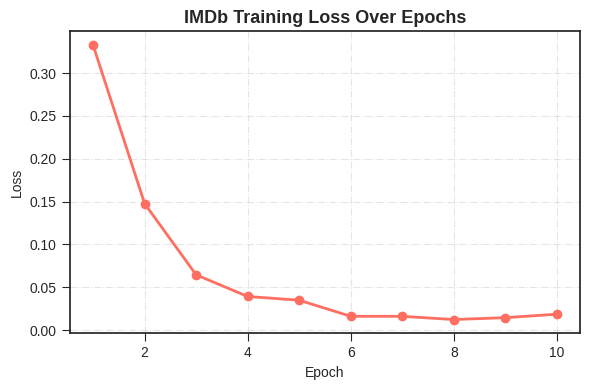

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', color='#ff6f61', linewidth=2)
plt.title('IMDb Training Loss Over Epochs', fontsize=13, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='-.', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluation: Predict and Compare Labels


In [ ]:

model.eval()
all_predictions = []
all_truths = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_truths.extend(labels.cpu().numpy())

# Accuracy, F1 Score, and Confusion Matrix


IMDb Test Accuracy: 0.9030
IMDb Test F1 Score: 0.9066



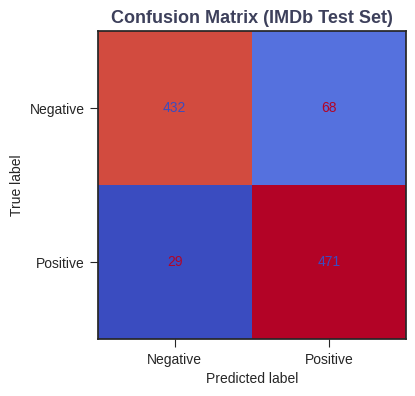

In [ ]:
final_accuracy = accuracy_score(all_truths, all_predictions)
final_f1 = f1_score(all_truths, all_predictions)

print(f"\nIMDb Test Accuracy: {final_accuracy:.4f}")
print(f"IMDb Test F1 Score: {final_f1:.4f}\n")

cm_final = confusion_matrix(all_truths, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(cmap='coolwarm', ax=ax, colorbar=False)
plt.title('Confusion Matrix (IMDb Test Set)', fontsize=13, fontweight='bold', color='#3d405b')
plt.show()

# Show Comments and Predicted Labels

In [ ]:
print("\nSample IMDb test reviews, true labels, and model predictions (after training):\n")
for i in range(5):
    print(f"Review: {test_texts[i][:120]}...")
    print(f"True label: {test_labels[i]}")
    print(f"Predicted label: {all_predictions[i]}")
    print("")


Sample IMDb test reviews, true labels, and model predictions (after training):

Review: "Film noir" is an overused expression when it comes to describing films. Every crime drama seems to be a "noir". But "Wh...
True label: 1
Predicted label: 1

Review: An amazing piece of film that was well-conceived and kept me on the edge of my seat. Brilliantly orchestrated in its tim...
True label: 1
Predicted label: 1

Review: The movie was very good. I'm an avid mystery fan and I usually figure out who is going to be killed and who did the kill...
True label: 1
Predicted label: 0

Review: Having grown up in the typing pool era and dealing with office politics and men who were apt to make a banquet of beauti...
True label: 1
Predicted label: 1

Review: Moscow Zero stole my money and I want it back! This is a horror movie, not thriller, not suspense, a horror movie. Yes, ...
True label: 0
Predicted label: 0

